In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../../")

In [5]:
import jaxquantum as jqt
from jax import jit, grad
from jax.experimental.ode import odeint
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import qutip as qt


from jax import device_put

# Apply the default theme
sns.set_theme()

from jax import config
config.update("jax_enable_x64", True)

from scipy.integrate import odeint as odeint_sp

Here, we compare QuTiP, SciPy, and JAX in their performance in finding the 

# QuTiP

In [6]:
def pi_pulse_qutip(ω_d):
    ω_q = 5.0 
    Ω = 0.1
    results = qt.mesolve([ω_q/2.0*qt.sigmaz(), # H0
                          [Ω*qt.sigmax(), 'cos(omega_d*t)']], # H1 
                         qt.ket2dm(qt.basis(2,0)), # |g><g|
                         np.linspace(0,np.pi/Ω,101),  # times, ωΩ*tf = π
                         args={"omega_d": ω_d}) # parameters
    return np.real((results.states[-1] * qt.sigmaz()).tr()) # returns <sz(tf)>

%timeit pi_pulse_qutip(5.0)

4.85 s ± 477 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
def pi_pulse_qutip_function(ω_d):
    ω_q = 5.0 
    Ω = 0.1
    results = qt.mesolve([ω_q/2.0*qt.sigmaz(), # H0
                          [Ω*qt.sigmax(), lambda t, args: np.cos(ω_q*t)]], # H1 
                         qt.ket2dm(qt.basis(2,0)), # |g><g|
                         np.linspace(0,np.pi/Ω,101))  # times, ωΩ*tf = π
    return np.real((results.states[-1] * qt.sigmaz()).tr()) # returns <sz(tf)>

%timeit pi_pulse_qutip_function(5.0)

16.7 ms ± 602 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# SciPy

In [25]:
omega_q = 5.0 #GHz
Omega = .01
H0 = omega_q/2.0*np.array(jqt.sigmaz())
H1 = Omega*np.array(jqt.sigmax())
g_state = np.array(jqt.ket2dm(jqt.basis(2,0)))
g_state_flat = np.concatenate([g_state.reshape(4,), np.zeros_like(g_state).reshape(4,)])
print(g_state_flat)

c_ops = np.array([])


def flat(rho):
    return np.concatenate([np.real(rho).reshape(4,),np.imag(rho).reshape(4,)])

def unflat(rho):
    return rho[:4].reshape(2,2) + 1.0j*(rho[4:].reshape(2,2))

def pi_exp_sp(omega_d):    
    t_list = np.linspace(0,np.pi/Omega,101)
    def H_func(rho_flat, t, H0_val, H1_val, c_ops_val):
        rho = unflat(rho_flat)
        fac = np.cos((omega_d+0j)*t)
        H = H0 + H1*fac
        rho_dot = -1.0j * (H @ rho) 
        rho_dot += -1.0j * (-rho @ H)
        return flat(rho_dot)
    
    states = odeint_sp(H_func, g_state_flat, t_list, (H0, H1, c_ops))
    final_state = states[-1]
    return np.real(np.trace(unflat(final_state) @ np.array(jqt.sigmaz())))

[1. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
%timeit pi_exp_sp(5.0)

# JAX

In [15]:
@jit
def pi_pulse_jax(ω_d):
    # parameters
    ω_q = 5.0 ; Ω = .1
    H0 = ω_q/2.0*jqt.sigmaz() ; H1 = Ω*jqt.sigmax()
    ψᵢ = jqt.ket2dm(jqt.basis(2,0)) + 0.0j
    ts = jnp.linspace(0,jnp.pi/Ω,101)
    @jit
    def ρ_dot(ρ, t, H0_val, H1_val):
        fac = jnp.cos((ω_d+0j)*t)
        H = H0_val + H1_val*fac
        dρdt = -1.0j * (H @ ρ)
        dρdt += -1.0j * (-ρ @ H)
        return dρdt
    
    states = odeint(ρ_dot, ψᵢ, ts, H0, H1) # replaces qutip.mesolve
    final_state = states[-1]
    return jnp.real(jnp.trace(final_state @ jqt.sigmaz()))

%timeit pi_pulse_jax(5.0)

3.05 ms ± 44.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
print(grad(pi_pulse_jax)(4.98))
%timeit grad(pi_pulse_jax)(4.98)

-7.867741661837401
16.7 ms ± 587 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Optimization w JAX

In [55]:
from jax.example_libraries.optimizers import adam
from jax import jit, value_and_grad

step_size = 2e-3
epochs = 500
opt_init, opt_update, get_params = adam(step_size)

@jit
def cost(x):
    return rabi_jax(x)

@jit
def update(x, opt_state):
    value, grads = value_and_grad(cost)(x)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

def run_training(opt_state, num_print = epochs//10):
        x = get_params(opt_state)
        log = {"cost":[], "time":[]}
        log["cost"].append(cost(x))

        for epoch in range(epochs):
            start_time = time.time()
            x, opt_state, loss_val = update(x, opt_state)
            log["cost"].append(loss_val)
            log["time"].append(time.time() - start_time)
            if epoch % num_print == 0:
                print("=" * 20)
                print("Epoch: ", epoch)
                print("Time: ", log["time"][-1])
                print("Cost: ", log["cost"][-1])
                print("omega_d: ", get_params(opt_state))
        return log, opt_state

In [56]:
opt_state = opt_init(4.9)
log, opt_state = run_training(opt_state)
omega_d_opt = get_params(opt_state)

Epoch:  0
Time:  1.8535079956054688
Cost:  0.36276322175814735
omega_d:  4.9019999999988055
Epoch:  50
Time:  0.014061927795410156
Cost:  -0.990672947194308
omega_d:  5.005776237884099
Epoch:  100
Time:  0.014203071594238281
Cost:  -0.9999957070494827
omega_d:  4.999637006169921
Epoch:  150
Time:  0.013881921768188477
Cost:  -0.9999973265378354
omega_d:  4.999465449770604
Epoch:  200
Time:  0.013788938522338867
Cost:  -0.9999976062915453
omega_d:  4.99949986291692
Epoch:  250
Time:  0.014482975006103516
Cost:  -0.9999976063008816
omega_d:  4.999500564774182
Epoch:  300
Time:  0.01601696014404297
Cost:  -0.9999976063086621
omega_d:  4.999500392461994
Epoch:  350
Time:  0.016466379165649414
Cost:  -0.9999976063086786
omega_d:  4.999500385994127
Epoch:  400
Time:  0.015768051147460938
Cost:  -0.9999976063086777
omega_d:  4.999500386686933
Epoch:  450
Time:  0.015664100646972656
Cost:  -0.9999976063086776
omega_d:  4.999500386746169


In [60]:
def plot_cost_vs_epoch(log):
    _, ax = plt.subplots(1, 1)
    ax.plot(log["cost"])
    ax.set_xlabel(r"${\rm epoch\ number}$")
    ax.set_ylabel(r"${\rm \langle \sigma_z (t_f) \rangle}$")
    ax.set_title(r"${\rm training\ history}$")
    return ax

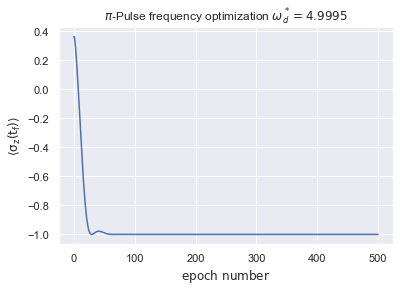

In [61]:
ax = plot_cost_vs_epoch(log)
ax.set_title(f"$\pi$-Pulse frequency optimization $\\omega_d^* = {omega_d_opt:.5}$")
plt.show()